## Test Pyro4 Setup

In [73]:
import Pyro4
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.SERIALIZERS_ACCEPTED.add("pickle")
bot = Pyro4.Proxy("PYRONAME:remotelocobot@172.17.0.2")
bot.test_connection()

'Connected!'

In [74]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs)

    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")

    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

In [75]:
import numpy as np
d3_40_colors_rgb: np.ndarray = np.array(
    [
        [31, 119, 180],
        [174, 199, 232],
        [255, 127, 14],
        [255, 187, 120],
        [44, 160, 44],
        [152, 223, 138],
        [214, 39, 40],
        [255, 152, 150],
        [148, 103, 189],
        [197, 176, 213],
        [140, 86, 75],
        [196, 156, 148],
        [227, 119, 194],
        [247, 182, 210],
        [127, 127, 127],
        [199, 199, 199],
        [188, 189, 34],
        [219, 219, 141],
        [23, 190, 207],
        [158, 218, 229],
        [57, 59, 121],
        [82, 84, 163],
        [107, 110, 207],
        [156, 158, 222],
        [99, 121, 57],
        [140, 162, 82],
        [181, 207, 107],
        [206, 219, 156],
        [140, 109, 49],
        [189, 158, 57],
        [231, 186, 82],
        [231, 203, 148],
        [132, 60, 57],
        [173, 73, 74],
        [214, 97, 107],
        [231, 150, 156],
        [123, 65, 115],
        [165, 81, 148],
        [206, 109, 189],
        [222, 158, 214],
    ],
    dtype=np.uint8,
)

In [4]:
rgb, d, segm = bot.get_rgbd_segm()

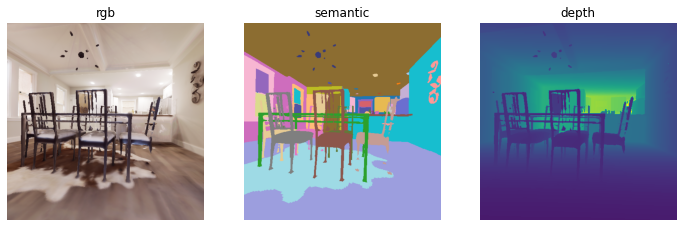

In [5]:
display_sample(rgb, segm, d)

In [96]:
from scipy.spatial.transform import Rotation

def transform_pose(XYZ, current_pose):
    """
    Transforms the point cloud into geocentric frame to account for
    camera position
    Input:
        XYZ                     : ...x3
    current_pose            : camera position (x, y, theta (radians))
    Output:
        XYZ : ...x3
    """
    R = Rotation.from_euler("Z", current_pose[2]).as_matrix()
    XYZ = np.matmul(XYZ.reshape(-1, 3), R.T).reshape((-1, 3))
    XYZ[:, 0] = XYZ[:, 0] + current_pose[0]
    XYZ[:, 1] = XYZ[:, 1] + current_pose[1]
    return XYZ

In [98]:
from copy import deepcopy as copy

def labelprop(src_img, src_depth, src_label, src_pose, base_pose, cur_depth):

    ### data needed to convert depth img to pointcloud ###
    # values extracted from pyrobot habitat agent
    intrinsic_mat = np.array([[256, 0, 256], [0, 256, 256], [0, 0, 1]])
    rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
    trans = np.array([0, 0, 0.6])
    # precompute some values necessary to depth to point cloud
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    height, width, channels = src_img.shape
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)

    ### calculate point cloud in different frmaes ###
    # point cloud in camera frmae
    depth = (src_depth.astype(np.float32) / 1000.0).reshape(-1)
    pts_in_cam = np.multiply(uv_one_in_cam, depth)
    pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
    # point cloud in robot base frame
    pts_in_base = pts_in_cam[:3, :].T
    pts_in_base = np.dot(pts_in_base, rot.T)
    pts_in_base = pts_in_base + trans.reshape(-1)
    # point cloud in world frame (pyrobot)
    pts_in_world = transform_pose(pts_in_base, src_pose)

    ### figure out unique label values in provided gt label which is greater than 0 ###
    unique_pix_value = np.unique(src_label.reshape(-1), axis=0)
    unique_pix_value = [i for i in unique_pix_value if np.linalg.norm(i) > 0]

    ### for each unique label, figure out points in world frame ###
    # first figure out pixel index
    indx = [zip(*np.where(src_label == i)) for i in unique_pix_value]
    # convert pix index to index in point cloud
    # refer this https://www.codepile.net/pile/bZqJbyNz
    indx = [[i[0] * width + i[1] for i in j] for j in indx]
    # take out points in world space correspoinding to each unique label
    req_pts_in_world_list = [pts_in_world[indx[i]] for i in range(len(indx))]

    # param useful to search nearest point cloud in a region
    kernal_size = 3

    # convert depth to point cloud in camera frame
    cur_depth = (cur_depth.astype(np.float32) / 1000.0).reshape(-1)
    cur_pts_in_cam = np.multiply(uv_one_in_cam, cur_depth)
    cur_pts_in_cam = np.concatenate(
        (cur_pts_in_cam, np.ones((1, cur_pts_in_cam.shape[1]))), axis=0
    )
    # convert point cloud in camera frame to base frame
    cur_pts_in_base = cur_pts_in_cam[:3, :].T
    cur_pts_in_base = np.dot(cur_pts_in_base, rot.T)
    cur_pts_in_base = cur_pts_in_base + trans.reshape(-1)
    # convert point cloud from base frame to world frame
    cur_pts_in_world = transform_pose(cur_pts_in_base, base_pose)

    ### generate label for new img ###
    # crete annotation files with all zeros
    annot_img = np.zeros((height, width))
    # do label prpogation for each unique label in provided gt seg label
    for i, (req_pts_in_world, pix_color) in enumerate(
        zip(req_pts_in_world_list, unique_pix_value)
    ):
        # convert point cloud for label from world pose to current (img_indx) base pose
        pts_in_cur_base = copy(req_pts_in_world)
        pts_in_cur_base = transform_pose(pts_in_cur_base, (-base_pose[0], -base_pose[1], 0))
        pts_in_cur_base = transform_pose(pts_in_cur_base, (0.0, 0.0, -base_pose[2]))

        # conver point from current base to current camera frame
        pts_in_cur_cam = pts_in_cur_base - trans.reshape(-1)
        pts_in_cur_cam = np.dot(pts_in_cur_cam, rot)

        # conver pts in current camera frame into 2D pix values
        pts_in_cur_img = np.matmul(intrinsic_mat, pts_in_cur_cam.T).T
        pts_in_cur_img /= pts_in_cur_img[:, 2].reshape([-1, 1])

        # filter out index which fall beyond the shape of img size
        filtered_img_indx = np.logical_and(
            np.logical_and(0 <= pts_in_cur_img[:, 0], pts_in_cur_img[:, 0] < height),
            np.logical_and(0 <= pts_in_cur_img[:, 1], pts_in_cur_img[:, 1] < width),
        )

        # only consider depth matching for these points
        # filter out point based on projected depth value wold frame, this helps us get rid of pixels for which view to the object is blocked by any other object, as in that was projected 3D point in wolrd frmae for the current pix won't match with 3D point in the gt provide label
        dist_thr = 5e-2  # this is in meter
        for pixel_index in range(len(filtered_img_indx)):
            if filtered_img_indx[pixel_index]:
                # search in the region
                gt_pix_depth_in_world = req_pts_in_world[pixel_index]
                p, q = np.meshgrid(
                    range(
                        int(pts_in_cur_img[pixel_index][1] - kernal_size),
                        int(pts_in_cur_img[pixel_index][1] + kernal_size),
                    ),
                    range(
                        int(pts_in_cur_img[pixel_index][0] - kernal_size),
                        int(pts_in_cur_img[pixel_index][0] + kernal_size),
                    ),
                )
                loc = p * width + q
                loc = loc.reshape(-1).astype(np.int32)
                loc = np.clip(loc, 0, width * height - 1).astype(np.int32)

                if (
                    min(np.linalg.norm(cur_pts_in_world[loc] - gt_pix_depth_in_world, axis=1))
                    > dist_thr
                ):
                    filtered_img_indx[pixel_index] = False

        # take out filtered pix values
        pts_in_cur_img = pts_in_cur_img[filtered_img_indx]

        # step to take care of quantization errors
        pts_in_cur_img = np.concatenate(
            (
                np.concatenate(
                    (
                        np.ceil(pts_in_cur_img[:, 0]).reshape(-1, 1),
                        np.ceil(pts_in_cur_img[:, 1]).reshape(-1, 1),
                    ),
                    axis=1,
                ),
                np.concatenate(
                    (
                        np.floor(pts_in_cur_img[:, 0]).reshape(-1, 1),
                        np.floor(pts_in_cur_img[:, 1]).reshape(-1, 1),
                    ),
                    axis=1,
                ),
                np.concatenate(
                    (
                        np.ceil(pts_in_cur_img[:, 0]).reshape(-1, 1),
                        np.floor(pts_in_cur_img[:, 1]).reshape(-1, 1),
                    ),
                    axis=1,
                ),
                np.concatenate(
                    (
                        np.floor(pts_in_cur_img[:, 0]).reshape(-1, 1),
                        np.ceil(pts_in_cur_img[:, 1]).reshape(-1, 1),
                    ),
                    axis=1,
                ),
            )
        )
        pts_in_cur_img = pts_in_cur_img[:, :2].astype(int)

        # filter out index which fall beyond the shape of img size, had to perform this step again to take care if any out of the image size point is introduced by the above quantization step
        pts_in_cur_img = pts_in_cur_img[
            np.logical_and(
                np.logical_and(0 <= pts_in_cur_img[:, 0], pts_in_cur_img[:, 0] < height),
                np.logical_and(0 <= pts_in_cur_img[:, 1], pts_in_cur_img[:, 1] < width),
            )
        ]

        # number of points for the label found in cur img
        # print("pts in cam = {}".format(len(pts_in_cur_cam)))

        # assign label to correspoinding pix values
        annot_img[pts_in_cur_img[:, 1], pts_in_cur_img[:, 0]] = pix_color

    return annot_img

In [83]:
asi = np.load('../../asi.jpg.npy')
asd = np.load('../../asd.npy')
acd = np.load('../../acd.npy')
asl = np.load('../../asl.npy')
asp = np.load('../../asp.npy')
acp = np.load('../../acp.npy')
arl = np.load('../../arl.npy')

osi = np.load('../../osi.npy')
osd = np.load('../../osd.npy')
ocd = np.load('../../ocd.npy')
osl = np.load('../../osl.npy')
osp = np.load('../../osp.npy')
ocp = np.load('../../ocp.npy')
orl = np.load('../../ors.npy')

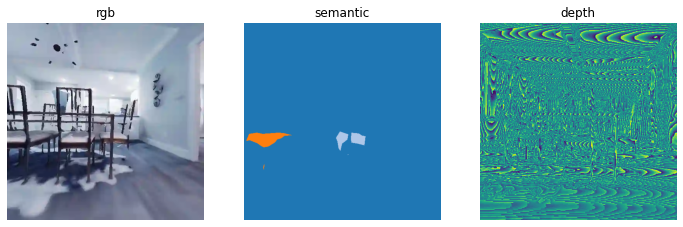

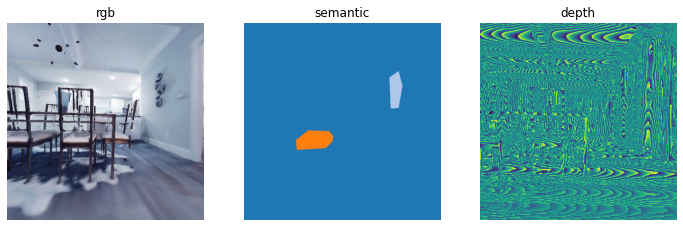

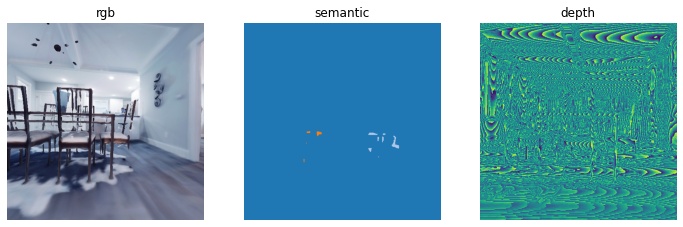

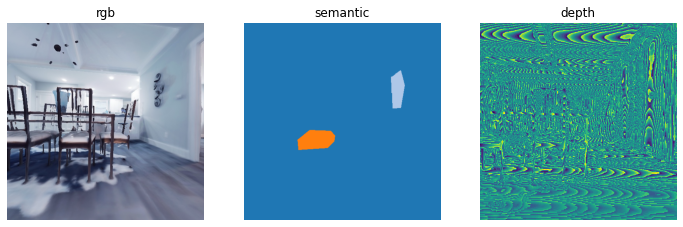

[-4.47034836e-08  0.00000000e+00  1.78813920e-07]
[-4.47034836e-08  0.00000000e+00  3.00000137e-01]
[-0.         -0.          0.01047194]
[-0.         -0.          0.02617986]


In [88]:
display_sample(asi, asl, asd)
display_sample(osi, osl, osd)
display_sample(rgb, arl, acd)
display_sample(rgb, orl, ocd)

In [114]:
print(asp)
print(acp)
print(osp)
print(ocp)

print(acd)
print(ocd)
print(np.mean(acd))
print(np.mean(ocd))
print(np.std(acd))
print(np.std(ocd))
print(np.min(acd))
print(np.min(ocd))
print(np.max(acd))
print(np.max(ocd))

print(asi[0])
print(osi[0])
print(np.mean(asi))
print(np.mean(osi))
print(np.std(asi))
print(np.std(osi))
print(np.min(asi))
print(np.min(osi))
print(np.max(asi))
print(np.max(osi))

[-4.47034836e-08  0.00000000e+00  1.78813920e-07]
[-4.47034836e-08  0.00000000e+00  3.00000137e-01]
[-0.         -0.          0.01047194]
[-0.         -0.          0.02617986]
[[1852 1851 1849 ... 1864 1861 1858]
 [1853 1851 1850 ... 1869 1866 1863]
 [1854 1853 1853 ... 1874 1871 1868]
 ...
 [ 643  644  644 ...  673  673  673]
 [ 641  641  641 ...  670  670  670]
 [ 639  639  639 ...  667  667  668]]
[[1961 1960 1960 ... 1576 1571 1565]
 [1969 1968 1968 ... 1576 1570 1565]
 [1977 1977 1976 ... 1576 1570 1565]
 ...
 [ 643  643  643 ...  674  674  674]
 [ 641  641  641 ...  671  671  671]
 [ 638  638  638 ...  668  668  669]]
2302.1510696411133
2211.7249336242676
1434.9327205627912
1425.0283037483946
0
638
8854
9873
[[165 179 197]
 [165 179 197]
 [165 179 197]
 ...
 [125 146 163]
 [125 146 163]
 [125 146 163]]
[[167 181 199]
 [167 181 199]
 [166 180 198]
 ...
 [129 143 162]
 [129 143 162]
 [129 143 162]]
144.6585324605306
144.23125712076822
52.185046365166485
52.404452686186474
0
0
255
2

In [113]:
res1 = labelprop(asi, asd, asl, asp, acp, acd)
print("cur wrong res:", np.unique(res1, return_counts=True))
print("wrong res:", np.unique(arl, return_counts=True))
print("wrong source:", np.unique(asl, return_counts=True))

res2 = labelprop(osi, osd, osl, osp, ocp, ocd)
print("cur right res:", np.unique(res2, return_counts=True))
print("right res:", np.unique(orl, return_counts=True))
print("right source:", np.unique(osl, return_counts=True))

cur wrong res: (array([0., 1., 2.]), array([261445,    533,    166]))
wrong res: (array([0., 1., 2.]), array([261445,    533,    166]))
wrong source: (array([0, 1, 2]), array([257930,   1757,   2457]))
cur right res: (array([0., 1., 2.]), array([255439,   2677,   4028]))
right res: (array([0., 1., 2.]), array([255439,   2677,   4028]))
right source: (array([0, 1, 2]), array([255785,   2480,   3879]))
